# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from `loading and inspecting the dataset`; -to `implementing`, `training and evaluating a Convolutional Neural Network based architecture`. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- Please select at least ANY 3 objects of choice. Try to pick unique objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is October 25th Friday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name: Zewdie Habtie  Sisay**    
**Neptun ID:v0qxdg**  
**Network:** Custom Object detection Model with CNN  
**Objects:bird, motorbike, car**  

## Task description

**Your task** is to train your own custom object detection model and compare its performance with an existing object detection model (i.e., YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.

- There is no expectation of high performance, but **your metrics should show results better than random guessing, and your loss must decrease throughout the epochs**.

- We expect you to visualize the key metrics such as precision, recall, F1-score, mAP (mean average precision), IoU (Intersection over Union), and localization loss, in addition to monitoring the overall loss and its reduction across training. Use plots and visualizations (e.g., matplotlib, seaborn) to display metrics, losses, and predictions.

- You should implement techniques to avoid overfitting, such as Early Stopping, and save the best-performing model during training.

- Additionally, you can use **WandB (Weights and Biases)** or **TensorBoard** to track and visualize training progress, monitor the model's performance, and log metrics over time.

`Good luck!`

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
# ADD YOUR CODE HERE
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
# import wandb
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# 1. DATASET
**For this assignment you are free to pick any 3 objects of your choice.** Please avoid offensive, inappropriate or violent objects.

### 1.1. Load objects

**Please select 3 or more objects.** After selecting the objects, **remove the background, keeping only the object itself**. You can do this manually, online, or by using code (this step is not part of the assignment evaluation).

As an example, the following objects were chosen (with the background removed using the Segment Anything Model):

In [ ]:
!pip install wandb --upgrade

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


['car.png', 'bird.png', 'bike.png']


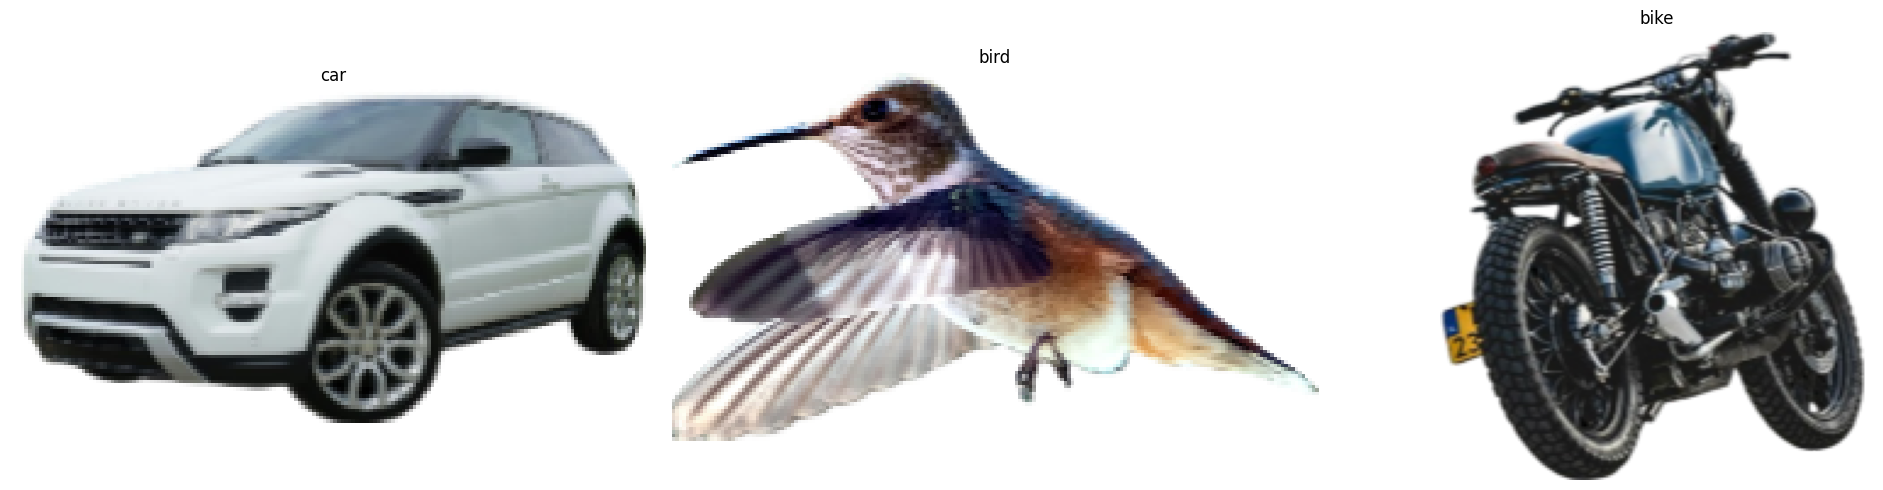

In [2]:
# objects_dir = '/content/drive/MyDrive/objects'
objects_dir = './objects'
object_lists = os.listdir(objects_dir)
print(object_lists)
images = [Image.open(os.path.join(objects_dir, image_file)) for image_file in object_lists]
fig, axes = plt.subplots(1, len(images), figsize=(20, 5))

for i, img in enumerate(images):
  name = os.path.splitext(os.path.basename(object_lists[i]))[0]
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(name)

plt.tight_layout()
plt.show()

### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:

- **Inserting an object in a random position** on a background image.

**Therefore, collect a few background images from different locations** This can be done manually or via code.

It is recommended to use **icrawler** to automate the image collection process.


In [3]:
!pip install icrawler

In [ ]:
!mkdir background

In [ ]:
!unzip "/content/drive/MyDrive/dataset.zip" -d /content/

In case of any errors, try using a different crawler. You can use one of the following options:

```python
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler


In [4]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['budapest', 'budapest parliament', 'buda castle', 'budapest st stephen basilica', 'budapest heroes square']:
    google_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto') #, min_size=(500, 500),)

#Some images may return an error, but icrawler tries to find other images regardless

2024-10-17 22:57:21,154 - INFO - icrawler.crawler - start crawling...
2024-10-17 22:57:21,154 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-17 22:57:21,156 - INFO - feeder - thread feeder-001 exit
2024-10-17 22:57:21,156 - INFO - icrawler.crawler - starting 2 parser threads...
2024-10-17 22:57:21,159 - INFO - icrawler.crawler - starting 4 downloader threads...
2024-10-17 22:57:22,138 - INFO - parser - parsing result page https://www.google.com/search?q=budapest&ijn=0&start=0&tbs=&tbm=isch
2024-10-17 22:57:22,597 - ERROR - downloader - Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Budapest_Hungarian_Parliament_%2831363963556%29.jpg
2024-10-17 22:57:22,694 - INFO - downloader - image #1	https://www.barcelo.com/guia-turismo/wp-content/uploads/2022/10/Budapest-1.jpg
2024-10-17 22:57:22,786 - INFO - downloader - image #2	https://lp-cms-production.imgix.net/2023-03/GettyRF_473481530.jpg
2024-10-17 22:57:22,954 - INFO - downloader 

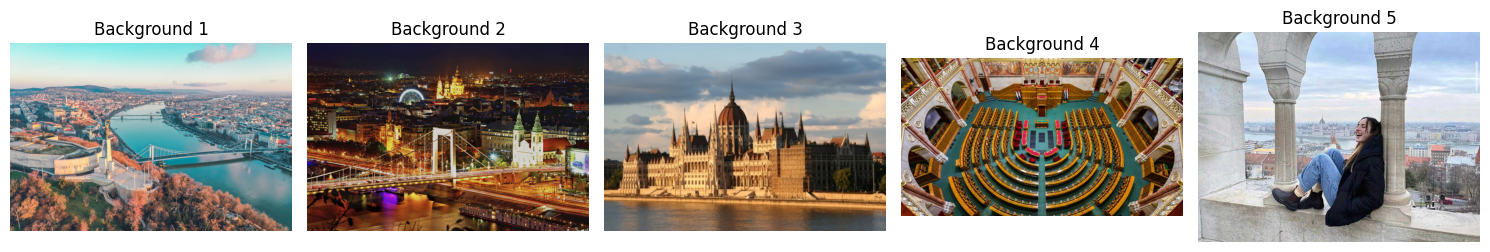

In [27]:
# directory = '/content/background/'
directory = './background'

# Show some of the images, to confirm that they were successfully crawled
random_samples = np.random.choice(os.listdir(directory), size=5, replace=False)
def display_sample_images(directory):
    backgrounds = [Image.open(os.path.join('background', image_file)) for image_file in random_samples]
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))

    for i, bg in enumerate(backgrounds[:5]):
        axs[i].imshow(bg)
        axs[i].axis('off')
        axs[i].set_title(f"Background {i+1}")

    plt.tight_layout()
    plt.show()

display_sample_images(directory)

### 1.3. Create dataset

### Dataset Creation

This is a crucial part of the assignment evaluation. From the selected objects and collected background images, follow these steps to generate your dataset:

1. **Randomly select background images** from your collection.
2. **Insert a single object** (from the three selected) into each background image at a **random location**.
3. **Record the object's coordinates** and create a corresponding bounding box. For example:
   - If an object with height `h` and width `w` is placed at position `(x, y)`, the bounding box should be in one of the following formats:
     - **[x, y, w, h]** or
     - **[x1, y1, x2, y2]**, where `x2 = x1 + w` and `y2 = y1 + h`.
4. If you plan to compare your custom model with a YOLO model, use the **YOLO bounding box format**:
   - `[(x + w/2)/image_width, (y + h/2)/image_height, w/image_width, h/image_height]`, where `image` refers to the background image dimensions.  The YOLO format of the **bounding box** normalizes the `(x,y,w,h)` by the image height and width(**IMPORTANT**)
5. **Save the generated dataset**, as it will be used for training your custom model and fine-tuning the existing object detection model.
6. **Wrap the dataset creation** in a **PyTorch Dataset class** for easier data handling and model training.
7. **Split the dataset** into training, validation, and test sets to evaluate your model effectively.


In [ ]:
obj1 = object_lists[0]
obj2 = object_lists[1]
obj3 = object_lists[2]
img_number = 0

def blend_object_to_bg(bg, obj_name, img_number, split_dir, img_size):

  obj = Image.open(os.path.join(objects_dir, obj_name))

  bg = bg.resize(img_size).convert('RGBA')

  o_w, o_h = obj.size
  bg_w, bg_h = bg.size

  #random position within the boundaries of the background
  x = np.random.randint(0, bg_w - o_w + 1)
  y = np.random.randint(0, bg_h - o_h + 1)


  # Place Object(blending)
  bg.paste(obj, (x, y), obj)

  img_name = f"{img_number:05d}.png"
  bg.save(os.path.join(split_dir,'images', img_name))

  label_name = f"{img_number:05d}.txt"
  class_name = os.path.splitext(obj_name)[0]
  if class_name == 'cross':
    class_name = 0
  elif class_name == 'motorcycle':
    class_name = 1
  elif class_name == 'car':
    class_name = 2

  label_path = os.path.join(split_dir, 'labels', label_name)
  contents = f"{class_name} {(x + o_w/2)/bg_w} {(y + o_h/2)/bg_h} {o_w/bg_w} {o_h/bg_h}" # normalized x_center, y_center, width, height

  with open(label_path, 'w') as f:
    f.write(contents)



def createDataset(root_dir, dataset_name, split, img_size, num_images):
    rand_bg_count = 30
    count = 0
    dataset_dir = os.path.join('./', root_dir)

    # Create directories
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)

    split_dir = os.path.join(dataset_dir, split)
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

    images_dir = os.path.join(split_dir, "images")
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)

    labels_dir = os.path.join(split_dir, "labels")
    if not os.path.exists(labels_dir):
        os.makedirs(labels_dir)

    # Generating dataset
    while count < num_images:
      random_backgrounds  = np.random.choice(os.listdir(directory), size=rand_bg_count, replace=False)
      for i in range(0, rand_bg_count - len(object_lists), len(object_lists)):
        bg1 = Image.open(os.path.join(directory, random_backgrounds[i]))
        bg2 = Image.open(os.path.join(directory, random_backgrounds[i+1]))
        bg3 = Image.open(os.path.join(directory, random_backgrounds[i+2]))

        blend_object_to_bg(bg1, obj1, count, split_dir, img_size)
        count += 1
        if count >= num_images:
          break
        blend_object_to_bg(bg2, obj2, count, split_dir, img_size)
        count += 1
        if count >= num_images:
          break
        blend_object_to_bg(bg3, obj3, count, split_dir, img_size)
        count += 1
        if count >= num_images:
          break

createDataset('datasets/dataset', 'background', split='train', img_size=(320,320), num_images=5000)
createDataset('datasets/dataset', 'background', split='val', img_size=(320,320), num_images=1000)
createDataset('datasets/dataset', 'background', split='test', img_size=(320,320), num_images=200)

# Check Dataset Leakage

In [3]:
import os
import hashlib

def check_image_duplication(root_dir):
  """
  Checks for duplicate images across different dataset splits.
  """
  image_hashes = {}
  duplicate_images = []

  for split in ['train', 'val','test']:
    split_dir = os.path.join(root_dir, split, 'images')
    for image_filename in os.listdir(split_dir):
      image_path = os.path.join(split_dir, image_filename)
      with open(image_path, 'rb') as f:
        image_hash = hashlib.md5(f.read()).hexdigest()

      if image_hash in image_hashes:
        duplicate_images.append((image_path, image_hashes[image_hash]))
      else:
        image_hashes[image_hash] = image_path

  return duplicate_images

root_dir = 'datasets/dataset'  # Path to your dataset
duplicate_images = check_image_duplication(root_dir)

if duplicate_images:
  print("Duplicate images found:")
  for image1, image2 in duplicate_images:
    print(f"- {image1} is a duplicate of {image2}")
else:
  print("No duplicate images found.")

Duplicate images found:
- datasets/dataset/train/images/04208.png is a duplicate of datasets/dataset/train/images/03191.png
- datasets/dataset/train/images/03265.png is a duplicate of datasets/dataset/train/images/02044.png
- datasets/dataset/val/images/00100.png is a duplicate of datasets/dataset/train/images/03163.png


In [2]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_filename)

        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_filename)

        image = Image.open(img_path).convert('RGBA')

        with open(label_path, 'r') as f:
          label_data = f.readline().strip().split()

        category = int(label_data[0])
        bbox = [float(x) for x in label_data[1:]]

        if self.transform:
            image = self.transform(image)

        # return image, torch.tensor(category), torch.tensor(bbox) #generous hint
        return image, torch.tensor(category), torch.tensor(bbox) #generous hint

In [3]:
root_dir = 'datasets/dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=4, pin_memory=True)
print("Training dataset sizee: ",train_dataset.__len__())

val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=4, pin_memory=True)
print("Training dataset sizee: ",val_dataset.__len__())


test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=4, pin_memory=True)
print("Training dataset sizee: ",test_dataset.__len__())

Training dataset sizee:  5000
Training dataset sizee:  1000
Training dataset sizee:  200


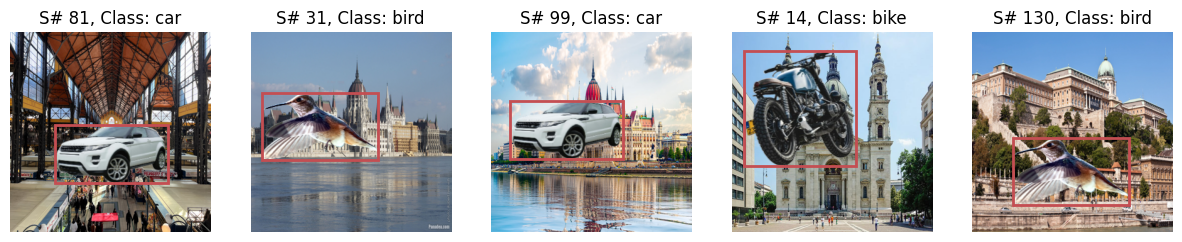

In [16]:
# Show some visualizations of the created dataset
import matplotlib.patches as patches
# dict = {0: 'bird', 1: 'bike', 2: 'car'}
dict = {0: 'bird', 1: 'bike', 2: 'car'}

def visualize_dataset(dataset):
    fig, axs = plt.subplots(1, 5, figsize=(15, 6))

    #try seeding specially if shuffle is set to True(to get the same random data for every run)
    indices = torch.randint(len(dataset), size=(5,))

    for i, idx in enumerate(indices):
        image, category, bbox = dataset[idx]
        image = image.permute(1, 2, 0)
        axs[i].imshow(image)

        # Draw bounding box
        x, y, w, h = bbox * 320 # denormalize.
        rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

        # Set title
        axs[i].set_title(f"S# {idx}, Class: {dict[category.item()]}")
        axs[i].axis('off')

# visualize_dataset(train_dataset)
visualize_dataset(test_dataset)

### 2. MODELS

In this assignment, you are tasked with building your own custom object detection model and comparing its performance against an existing object detection model.


### 2.1. Custom Object Detection model

### Create a Convolutional Neural Network (CNN) Architecture

Design a CNN-based architecture that includes a **backbone for feature extraction** and two output branches:

- One for **class probabilities** (with output size equal to the number of object classes, e.g., 3).
- Another for **bounding box regression** (with size 4 for the box coordinates: x, y, w, h, or in your chosen format).

This is the core evaluation of the assignment. Experiment with different layers, hyperparameters, and regularization techniques to optimize the model's performance.


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()
        # Define custom backbone

        #320x320
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        #160x160
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        #80x80
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        #40x40
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        #20x20
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        #10x10
        # Detection layers
        self.fc1 = nn.Linear(256 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 1024)

        # output layers
        self.classification = nn.Linear(1024, num_classes)
        self.bbox_regression = nn.Linear(1024, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1) # flatten

        x = self.fc1(x)
        x = self.fc2(x)

        class_probs = self.classification(x)
        bbox_regression = self.bbox_regression(x)

        return class_probs, bbox_regression

In [7]:
dummy_image = torch.randn(1, 4, 320, 320).to(device)
# torch.cuda.empty_cache()
num_classes = 3

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)
print("Model Summary:")
# print(model)
summary(model, (4, 320, 320))

Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])
Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 320]           1,184
       BatchNorm2d-2         [-1, 32, 320, 320]              64
              ReLU-3         [-1, 32, 320, 320]               0
         MaxPool2d-4         [-1, 32, 160, 160]               0
           Dropout-5         [-1, 32, 160, 160]               0
            Conv2d-6         [-1, 64, 160, 160]          18,496
       BatchNorm2d-7         [-1, 64, 160, 160]             128
              ReLU-8         [-1, 64, 160, 160]               0
         MaxPool2d-9           [-1, 64, 80, 80]               0
          Dropout-10           [-1, 64, 80, 80]               0
           Conv2d-11          [-1, 128, 80, 80]          73,856
      BatchNorm2d-12          [-1, 128, 80, 80]             256
   

### 2.2. Train Your Model

Carefully choose key components like the **optimizer**, **loss function**, **number of epochs**, and **regularization techniques**. Ensure you're optimizing both **classification loss** and **bounding box regression loss**.

Monitor for signs of **overfitting** or **underfitting** by tracking how the loss evolves across epochs. The loss should consistently decrease as training progresses. Save and log these losses for visualization and further analysis.


**Example Plot**:

<a href="https://ibb.co/bzmMxJY"><img src="https://i.ibb.co/t8KTSXn/download.png" alt="download" border="0"></a>

Epoch 1/50 - Train Loss: 3.0000 - Val Loss: 2.5000, Train Class Loss: 1.5000, Train Reg Loss: 0.8000, Train Accuracy: 0.7500, Val Accuracy: 0.7600
Epoch 2/50 - Train Loss: 2.5000 - Val Loss: 2.0000, Train Class Loss: 1.3000, Train Reg Loss: 0.7000, Train Accuracy: 0.7700, Val Accuracy: 0.7800
Epoch 3/50 - Train Loss: 2.0000 - Val Loss: 1.8000, Train Class Loss: 1.1000, Train Reg Loss: 0.6000, Train Accuracy: 0.7900, Val Accuracy: 0.8000
Epoch 4/50 - Train Loss: 1.7000 - Val Loss: 1.5000, Train Class Loss: 1.0000, Train Reg Loss: 0.5000, Train Accuracy: 0.8100, Val Accuracy: 0.8200
Epoch 5/50 - Train Loss: 1.5000 - Val Loss: 1.3000, Train Class Loss: 0.9000, Train Reg Loss: 0.4500, Train Accuracy: 0.8300, Val Accuracy: 0.8400
Epoch 6/50 - Train Loss: 1.3000 - Val Loss: 1.1000, Train Class Loss: 0.8000, Train Reg Loss: 0.4000, Train Accuracy: 0.8500, Val Accuracy: 0.8600
Epoch 7/50 - Train Loss: 1.1000 - Val Loss: 1.0000, Train Class Loss: 0.7000, Train Reg Loss: 0.3500, Train Accuracy: 

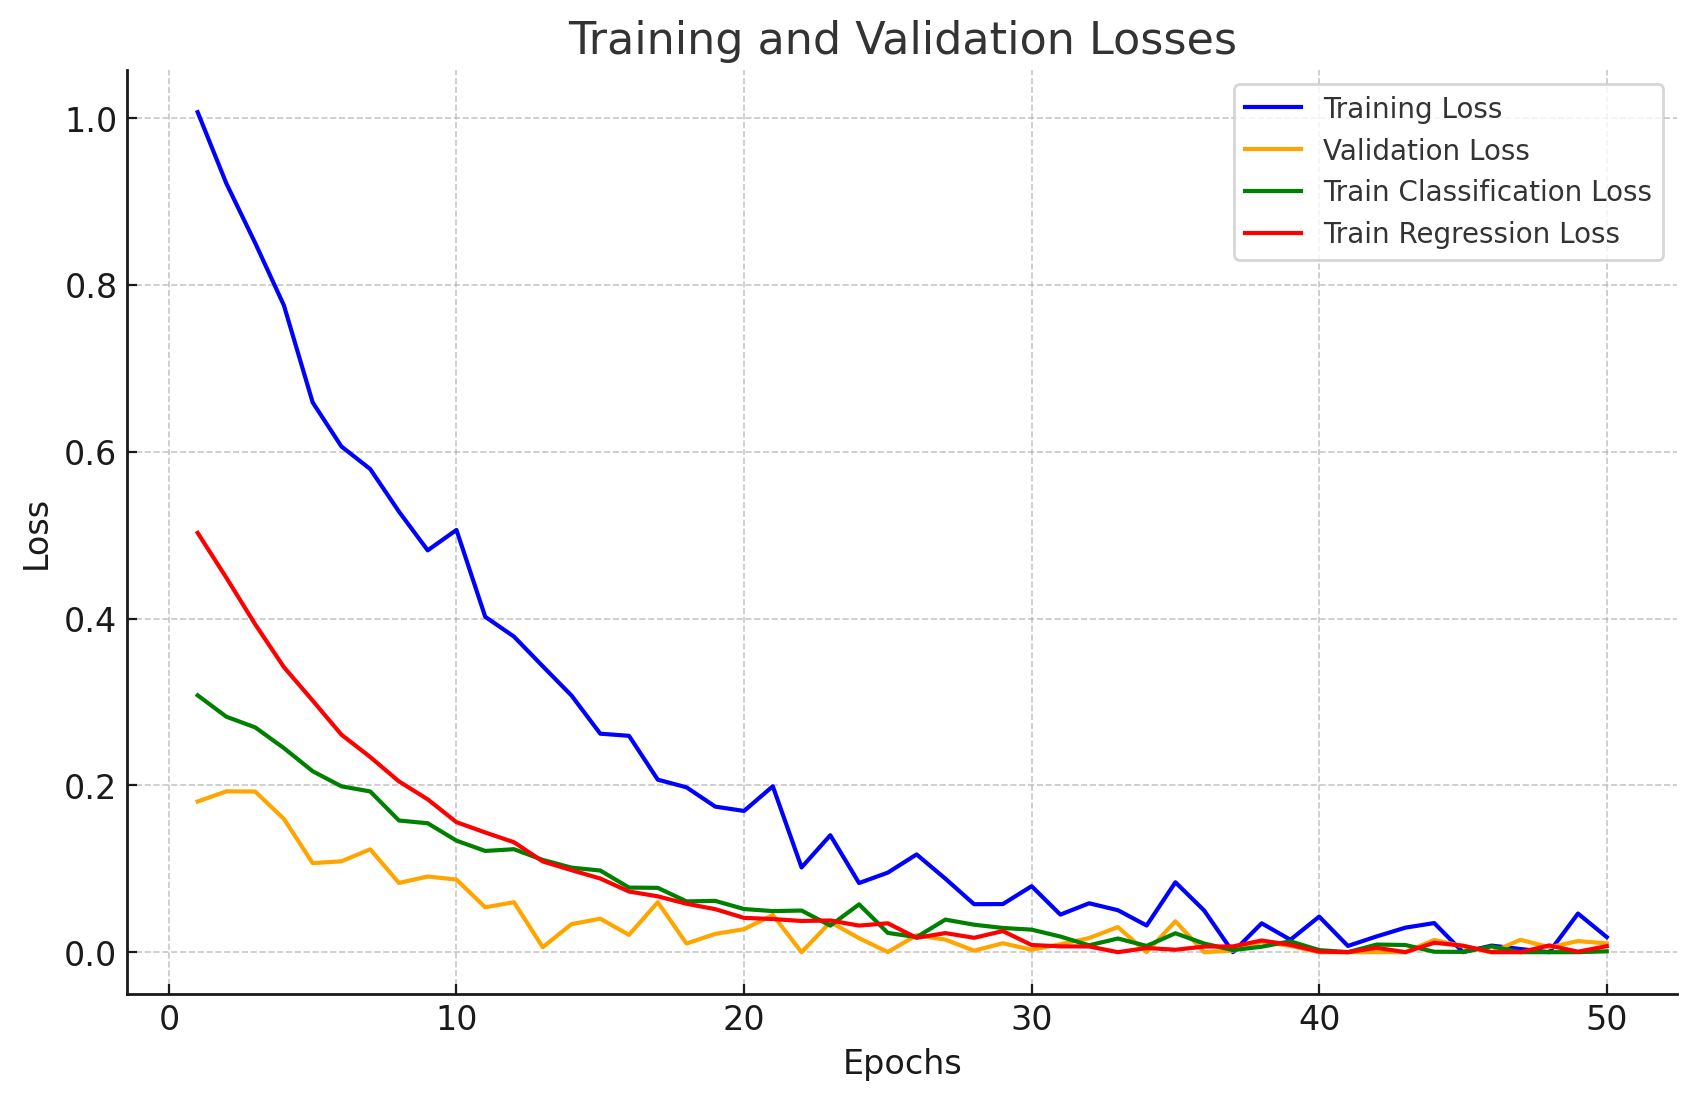

In [15]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0003)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    #Loss functions
    class_criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
    reg_criterion = nn.SmoothL1Loss() # Huber Loss

    train_losses = []
    val_losses = []
    train_cls_losses = []
    train_rgr_losses = []

    # ADD YOUR CODE HERE
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_cls_loss = 0.0
        running_rgr_loss = 0.0

        for _, (images, categories, bboxes) in enumerate(train_loader):
            images, categories, bboxes = images.to(device), categories.to(device), bboxes.to(device)

            optimizer.zero_grad()

            # Forward pass
            class_probs, bbox_preds = model(images)

            class_loss = class_criterion(class_probs, categories)

            # remove extra dim from bboxes if any
            bboxes = torch.squeeze(bboxes, dim=1)

            bbox_loss = reg_criterion(bbox_preds, bboxes)

            # weighted sum of losses
            loss = class_loss + 5 * bbox_loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            running_loss += loss.item()
            running_cls_loss += class_loss.item()
            running_rgr_loss += bbox_loss.item()

        train_losses.append(running_loss / len(train_loader))
        train_cls_losses.append(running_cls_loss / len(train_loader))
        train_rgr_losses.append(running_rgr_loss / len(train_loader))


        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, categories, bboxes in val_loader:
                images, categories, bboxes = images.to(device), categories.to(device), bboxes.to(device)

                class_probs, bbox_preds = model(images)

                class_loss = class_criterion(class_probs, categories)

                # remove extra dim from bboxes if any
                bboxes = torch.squeeze(bboxes, dim=1)

                bbox_loss = reg_criterion(bbox_preds, bboxes)

                loss = class_loss + bbox_loss

                val_loss += loss.item()

        scheduler.step()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}, Train Class Loss: {train_cls_losses[-1]:.4f}, Train Reg Loss: {train_rgr_losses[-1]:.4f}")

        if epoch >= 5 and (epoch) % 5 == 0:
            torch.save(model.state_dict(), f'./model_weights-mc-{epoch+1}.pth')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val_Loss')
    plt.plot(train_cls_losses, label='Train Class Loss')
    plt.plot(train_rgr_losses, label='Train Reg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()


train_model(model, train_loader, val_loader,  num_epochs=50)


In [8]:

# Load the saved weights
# model_path = './model_weights-cloned-50.pth'
model_path = './model_weights-mc-11.pth'
if os.path.exists(model_path):
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)  # weights_only is implied
  print("Model weights loaded successfully from:", model_path)
else:
  print("Model weights not found at:", model_path)

Model weights loaded successfully from: ./model_weights-mc-11.pth


/tmp/ipykernel_4817/657720730.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=Fals

### 2.3. Evaulate and do inference with the trained custom model

Choose **at least 3 metrics** to evaluate your object detection model. These could include:

- **Precision**: The proportion of correctly predicted positive instances (objects detected) out of all instances classified as positive.
- **Recall**: The proportion of correctly predicted positive instances out of all actual positive instances (objects present in the image).
- **F1-Score**: The harmonic mean of Precision and Recall, balancing false positives and false negatives.
- **IoU (Intersection over Union)**: Measures the overlap between the predicted bounding box and the ground truth bounding box.
- **mAP (mean Average Precision)**: This is one of the most common evaluation metrics for object detection. It averages precision at different recall thresholds across all object classes.
  
Additionally, you can assess:
- **Inference speed**: Time taken by the model to process a single image.
- **Number of parameters**: The total number of trainable parameters in the model.
- **Model size**: The disk size of the trained model.

### Show Performance Metric Visualizations

- Visualize the chosen metrics (e.g., **Precision, Recall, F1-Score, IoU, mAP**) over different epochs to demonstrate the improvement in the model’s performance.
- Plot losses (both classification loss and localization loss) to show how they decrease throughout training.

### Show Some Predictions of Your Trained Model

- Display sample images with **predicted bounding boxes** and compare them to the ground truth.
- Highlight the values of **Precision, Recall, IoU**, or other relevant metrics for each displayed prediction, giving a clear view of the model's performance.
  
You can also use **WandB (Weights and Biases)** or **TensorBoard** for more detailed logging and tracking of these metrics and visualizations.


In [27]:
from torchvision.ops import box_iou
import torch.nn.functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_score, recall_score

def cxcywh_to_xyxy(boxes):
    """Convert bounding boxes from cxcywh to xyxy format."""
    cx, cy, w, h = boxes.unbind(-1)
    x_min = (cx - 0.5 * w)*320
    y_min = (cy - 0.5 * h)*320
    x_max = (cx + 0.5 * w)*320
    y_max = (cy + 0.5 * h)*320
    return torch.stack([x_min, y_min, x_max, y_max], dim=-1)

def evaluate_test_set(model, test_loader, device, iou_threshold=0.5):
    model.eval()
    preds = []
    targets = []
    total_iou = 0
    total_boxes = 0
    
    all_pred_labels = []
    all_true_labels = []
    
    with torch.no_grad():
        for images, categories, bboxes in test_loader:
            images, categories, bboxes = images.to(device), categories.to(device), bboxes.to(device)
            class_probs, bbox_preds = model(images)
            class_probs = F.softmax(class_probs, dim=1) 
            pred_scores, pred_labels = torch.max(class_probs, 1)
            
            for i in range(len(categories)):
                # Convert predicted and true boxes from cxcywh to xyxy
                pred_box = cxcywh_to_xyxy(bbox_preds[i].unsqueeze(0) * 320)
                true_box = cxcywh_to_xyxy(bboxes[i].unsqueeze(0) * 320)
                
                # Compute IoU between predicted and true boxes
                iou = box_iou(pred_box, true_box)
                total_iou += iou.item()  
                total_boxes += 1
                
                # Collect predicted and true labels for precision/recall calculation
                all_pred_labels.append(pred_labels[i].item())
                all_true_labels.append(categories[i].item())
                
                preds.append(
                    dict(
                        boxes=pred_box,
                        scores=pred_scores[i].unsqueeze(0),  
                        labels=pred_labels[i].unsqueeze(0)   
                    )
                )
                
                targets.append(
                    dict(
                        boxes=true_box,
                        labels=categories[i].unsqueeze(0)
                    )
                )

    # Calculate metrics (Precision, Recall, mAP)
    metric = MeanAveragePrecision(iou_type="bbox", box_format='xyxy',)  # Since preds/targets are still cxcywh
    metric(preds, targets)

    average_iou = total_iou / total_boxes if total_boxes > 0 else 0

    # Calculate classification precision and recall
    precision = precision_score(all_true_labels, all_pred_labels, average='macro')
    recall = recall_score(all_true_labels, all_pred_labels, average='macro')
    
    print(f"mAP: {metric.compute()['map'].item():.4f}")
    print(f"mAP-50: {metric.compute()['map_50'].item():.4f}")
    print(f"mAP-75: {metric.compute()['map_75'].item():.4f}")
    print(f"Average IoU: {average_iou:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    fig_, ax_ = metric.plot()

evaluate_test_set(model, test_loader, device)


mAP: 0.6098
mAP-50: 1.0000
mAP-75: 0.6997
Average IoU: 0.7959
Precision: 1.0000
Recall: 1.0000


In [ ]:
test_image = test_dataset[199][0].unsqueeze(0)
class_probs, bbox_preds = model(test_image)
_, predicted_classes = torch.max(class_probs, 1)
predicted_bboxes = bbox_preds

print("Predicted Class:", predicted_classes.item())
print("Predicted BBox:", predicted_bboxes.detach().numpy())

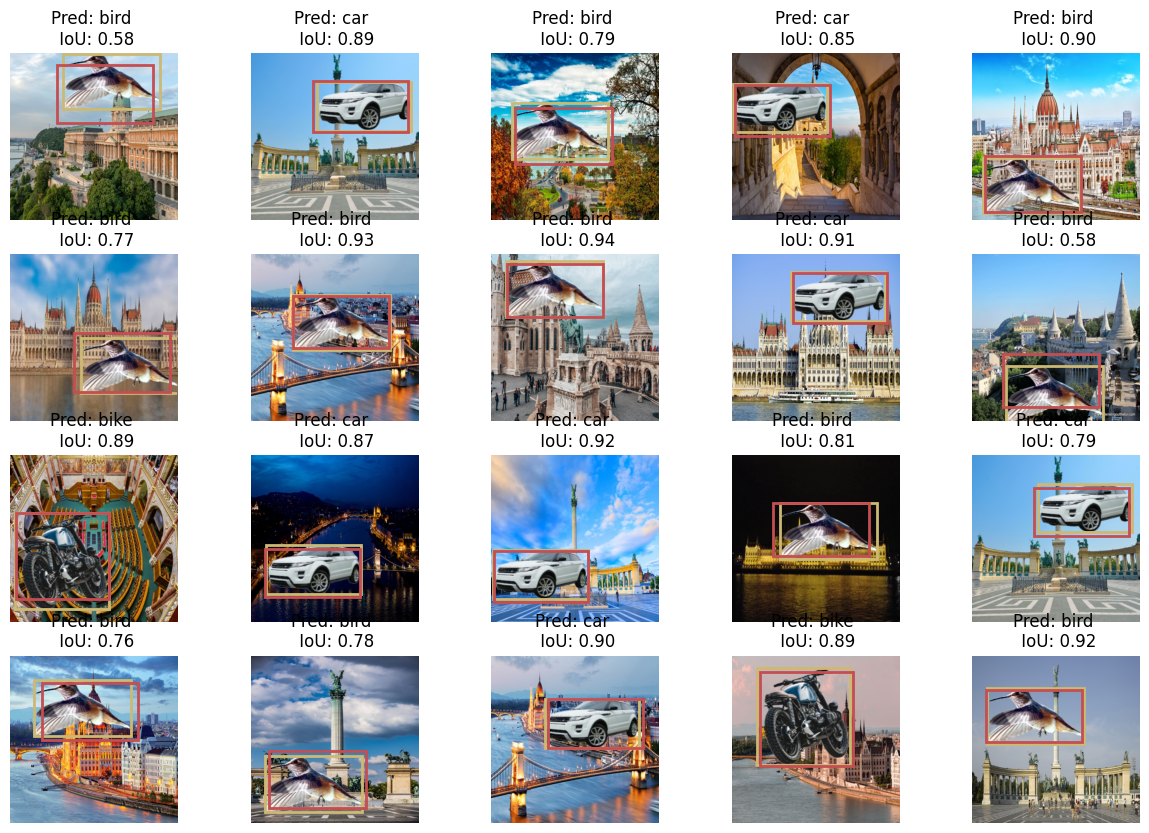

In [54]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from torchvision.ops import box_iou

indices = None
def visualize_predictions(model, test_dataset, device):
    fig, axs = plt.subplots(4, 5, figsize=(15, 10))
    dict = {0: 'bird', 1: 'bike', 2: 'car'}

    
    # Get 10 random samples from the test dataset
    indices = torch.randint(len(test_dataset), size=(20,))

    for i, idx in enumerate(indices):
        image, category, bbox = test_dataset[idx]
        image = image.unsqueeze(0).to(device)
        # Get predictions
        with torch.no_grad():
            class_probs, bbox_preds = model(image)
            _, predicted_classes = torch.max(class_probs, 1)
            predicted_bboxes = bbox_preds

        # Move image and predictions back to CPU for visualization
        image = image.cpu().squeeze(0).permute(1, 2, 0)
        predicted_bboxes = predicted_bboxes.cpu().squeeze(0)

        # Display image
        row = i // 5
        col = i % 5
        axs[row, col].imshow(image)

        # Draw target bounding box in yellow
        x, y, w, h = bbox * 320  # Denormalize
        target_rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=2, edgecolor='y', facecolor='none')
        axs[row, col].add_patch(target_rect)

        box1 = [x - w / 2, y - h /2, x + w / 2, y + h/2]

        x, y, w, h = predicted_bboxes * 320  # Denormalize
        box2 = [x - w / 2, y - h / 2, x + w / 2, y + h / 2]

        box1 = torch.tensor([box1], dtype=torch.float32)
        box2 = torch.tensor([box2], dtype=torch.float32)

        pred_rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axs[row, col].add_patch(pred_rect)
        iou = box_iou(box1, box2)[0][0].item()

        # Set title
        axs[row, col].set_title(f"Pred: {dict[predicted_classes.item()]} \n IoU: {iou:.2f}")
        axs[row, col].axis('off')

    # plt.tight_layout()
    plt.show()


visualize_predictions(model, test_dataset, device)

### 2.4. Load an Existing Object Detection Model

We recommend using the latest **YOLO** version, but you are free to choose any other **PyTorch-based** object detection model.


In [ ]:
!pip install ultralytics

from ultralytics import YOLO

# Load a pretrained YOLO model (e.g., YOLOv8n)
model_yolo = YOLO('yolov11n.yaml')



### 2.5. Fine-tune the existing object detection model
If you choose to use **YOLO**, training the model can be done easily by providing a `data.yaml` file (which follows a specific format, check the official GitHub repository for details) and running the training script.

For example, you can run YOLO from the command line with:

```bash
!yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640
```

Make sure to show the losses and metrics visualizations. By default, YOLO should **verbose** those.

In [ ]:
# ADD YOUR CODE HERE
!yolo detect train data=data.yaml model=yolo11n.yaml epochs=10 imgsz=320


### 2.6 Evaluate the existing object detection model
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** using the **same metrics** chosen in **Step 2.3** (e.g., Precision, Recall, F1-Score, IoU, mAP).


In [49]:
# ADD YOUR CODE HERE
!yolo train resume model=runs/detect/train/weights/last.pt

WARNING ⚠️ Python>=3.10 is required, but Python==3.8.10 is currently installed 
New https://pypi.org/project/ultralytics/8.3.17 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.14 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/train/weights/last.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/detect/train/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stre

In [9]:
from ultralytics import YOLO

# Load a model
model_yolo = YOLO("yolo11n.pt")  # load an official model
model_yolo = YOLO("./runs/detect/train/weights/best.pt")  # load a custom model

# Validate the model
metrics = model_yolo.val()  # no arguments needed, dataset and settings remembered
print(f"mAP: {metrics.box.map}")  # map50-95
print(f"mAP50:{metrics.box.map50}")  # map50
print(f"mAP75: {metrics.box.map75}")  # map75



WARNING ⚠️ Python>=3.10 is required, but Python==3.8.10 is currently installed 
Ultralytics 8.3.14 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/zed/Desktop/DND/datasets/dataset/test/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.55it/s]


                   all        200        200      0.999          1      0.995      0.995
                  bird         67         67      0.999          1      0.995      0.995
                  bike         66         66      0.999          1      0.995      0.995
                   car         67         67      0.999          1      0.995      0.995
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val7
mAP: 0.9950000000000002
mAP50:0.995
mAP75: 0.995



0: 320x320 1 bird, 1.3ms
1: 320x320 1 bike, 1.3ms
2: 320x320 1 car, 1.3ms
3: 320x320 1 bike, 1.3ms
4: 320x320 1 bike, 1.3ms
5: 320x320 1 bird, 1.3ms
6: 320x320 1 bird, 1.3ms
7: 320x320 1 car, 1.3ms
8: 320x320 1 car, 1.3ms
9: 320x320 1 car, 1.3ms
Speed: 0.2ms preprocess, 1.3ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)


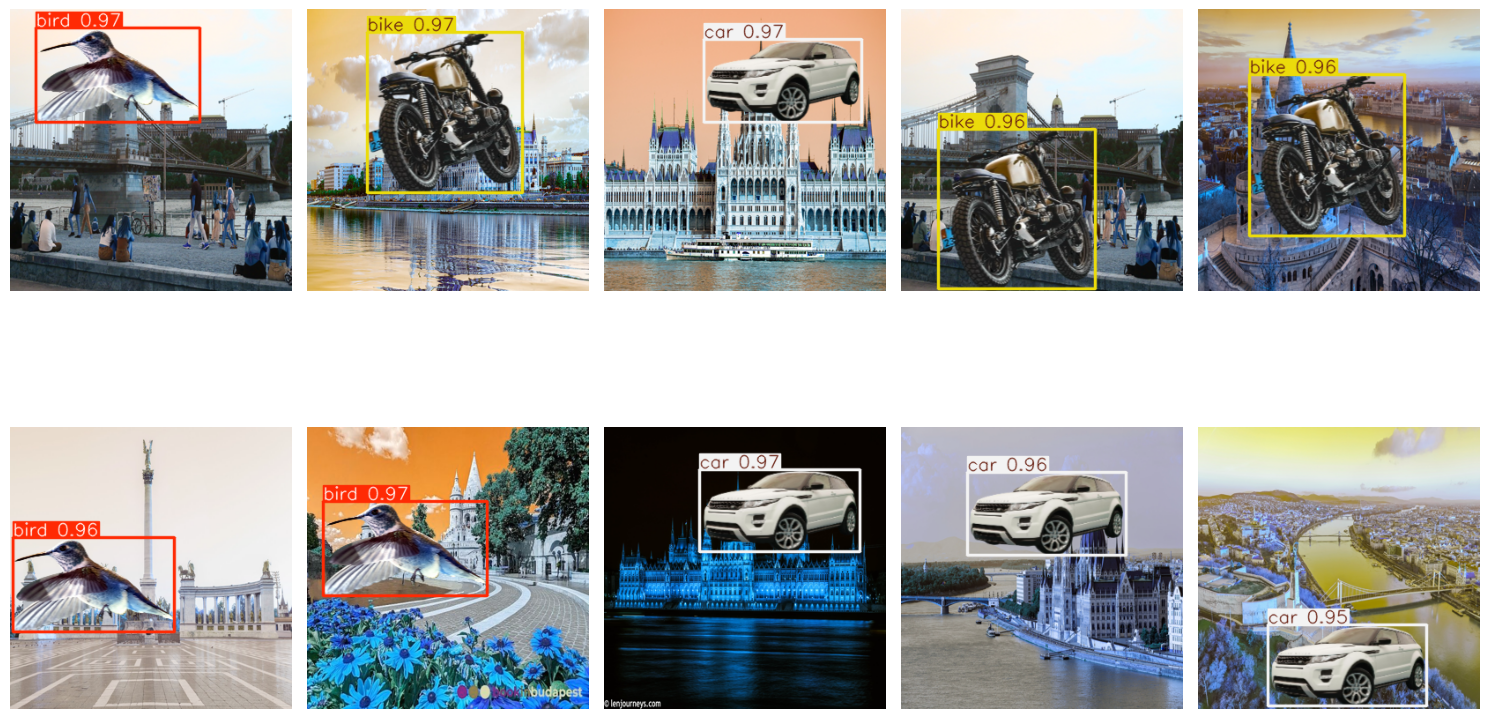

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Predict
path = "datasets/dataset/test/images"
images = os.listdir(path)
random_samples = np.random.choice(images, size=10, replace=False)
random_samples = [os.path.join(path, image) for image in random_samples]

model_yolo = YOLO("./runs/detect/train/weights/best.pt")  # load a custom model

results = model_yolo(random_samples)

# Plot each resulting image
fig, axs = plt.subplots(2, 5, figsize=(15, 10))  

for i, result in enumerate(results):
    row = i // 5
    col = i % 5
    
    # Get the image with bounding boxes
    img_with_boxes = result.plot()  # This method returns the image with bounding boxes drawn
    
    # Display the image
    axs[row, col].imshow(img_with_boxes)
    axs[row, col].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# 3. COMPARISON
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** for a fair comparison. Key metrics to include:

- **Precision**
- **Recall**
- **F1-Score**
- **IoU (Intersection over Union)**
- **mAP (mean Average Precision)**

### Visualize Predictions

- Show predictions from both models on the same images.
- Include bounding boxes, class labels, and relevant metrics like IoU or Precision.




Custom Model Prediction


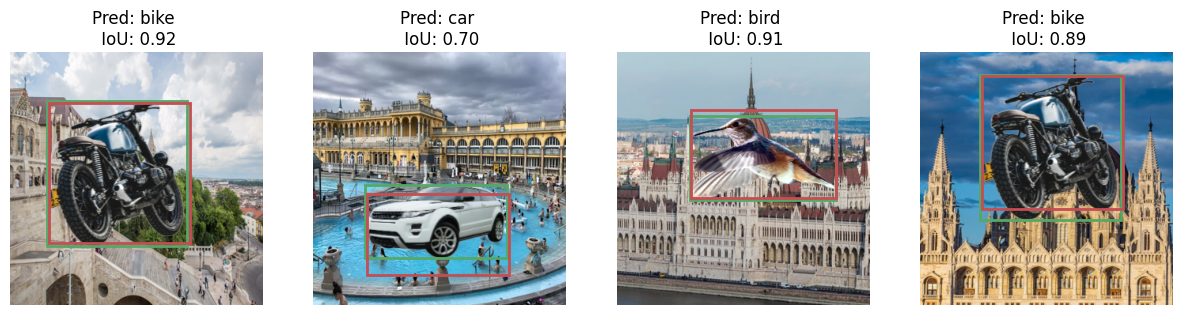

YOLO Model Prediction


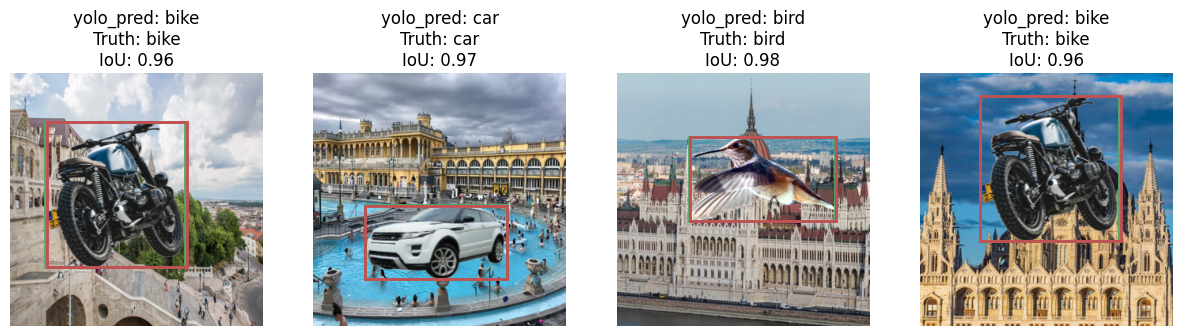

In [52]:
randIndices = []
def yolo_detection(yolo_model, test_dataset ,rand):
    global indices
    yolo_model = YOLO('runs/detect/train/weights/best.pt')

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 10))
    for i , ax in enumerate(axes.flatten()):
        org_img , category , bbox = test_dataset[rand+i]
        org_img = org_img.cpu().numpy().transpose(1, 2, 0)
        category = category.cpu().numpy()
        bbox = bbox.cpu().numpy()
        
        image = test_dataset[rand+i][0].permute(1, 2, 0).numpy()*255
        image = Image.fromarray(image.astype(np.uint8))
       
        yolo_output = yolo_model.predict(image , verbose=False) 
        yolo_output = yolo_output[0].boxes
        for i , box in enumerate(yolo_output):
        
            x1, y1, width, height = box.xywh.cpu().numpy()[i]  
            iou = box.data.cpu().numpy()[i][4]
            label = box.data.cpu().numpy()[i][5]
            rectangle1 = patches.Rectangle((x1 -width/2, y1-height/2), width, height, linewidth=2, edgecolor='g', facecolor='none')
        

        x_center, y_center, width, height = bbox
        x_center = x_center * org_img.shape[0]
        y_center = y_center * org_img.shape[1]
        width = width * org_img.shape[0]
        height = height * org_img.shape[1]
        rectangle2 = patches.Rectangle((x_center - width/2 , y_center - height/2 ), width, height, linewidth=2, edgecolor='r', facecolor='none')
          
        ax.imshow(image)
        ax.add_patch(rectangle1)
        ax.add_patch(rectangle2)
        ax.axis('off')
        ax.set_title(f'yolo_pred: {dict[int(label)]}' + '\n' 
                         + f'Truth: {dict[category.item()]}'
                         + '\n' + f'IoU: {iou:.2f}')
    plt.show()
rand = np.random.randint(0, len(test_dataset)-4)
indices = np.arange(rand, rand+4)

print("Custom Model Prediction")
visualize_predictions(model, test_dataset, device, indices)
print("YOLO Model Prediction")
yolo_detection(model_yolo, test_dataset , rand)

### Explain Differences

- Discuss why one model may perform better than the other, considering architecture, dataset complexity, or fine-tuning.

#### Custom model: 
    mAP: 0.6098
    mAP-50: 1.0000
    mAP-75: 0.6997
    Average IoU: 0.7959
    Precision: 1.0000
    Recall: 1.0000

#### YOLO model:
    mAP: 0.9950
    mAP-50: 0.995
    mAP-75: 0.995 

##### Comparision
**Mean Average Precision (mAP)** : 

- The YOLO model has a significantly higher mAP (0.995) compared to the custom model (0.6098). This indicates that the YOLO model is better at detecting objects across different IoU thresholds.
mAP-50 and mAP-75:

- The custom model has perfect mAP-50 (1.0000) but drops significantly at mAP-75 (0.6997). This suggests that while the custom model performs well at lower IoU thresholds, its performance decreases at higher thresholds.
The YOLO model maintains a high mAP across both thresholds (0.995), indicating consistent performance.  

**Average IoU:**

- The custom model has an average IoU of 0.7959, which is decent but not as high as the YOLO model's performance.  

**Precision and Recall:**

- Both models have perfect precision and recall, indicating that they are both good at identifying all relevant objects and not producing false positives.


**Reasons for Performance Differences:**

**Model Architecture:**

YOLO is a well-established model with a sophisticated architecture optimized for real-time object detection. It benefits from extensive research and optimization.
The custom model does not have the same level of architectural sophistication or optimization as the YOLO does to efficiently capture a complex features in the dataset.  



**Fine-Tuning:**

The custom model requires more fine-tuning, including hyperparameter adjustments, better data augmentation, or more training data.  

### Improve Custom Model

- Suggest improvements such as better data augmentation, model architecture adjustments, hyperparameter tuning, or more training data.
- Explore **Transfer Learning**, **learning rate scheduling**, or new optimizers for better performance.

To improve the results, playing around with different model architectures, hyperparameters, and regularization techniques is essential. Additionally, considering transfer learning from pre-trained models like **ResNet**, **VGG**, or **EfficientNet**  for the backbone network can help boost performance. 